In [1]:
# this file calculates raster statistics of a specified polygon. 

In [10]:
import geopandas as gpd
import rasterio as rio
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.mask import mask
import rasterstats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from os import path
from shapely.geometry import box

In [6]:
# identify working directories for exports
current_dir = os.getcwd() # current directory for scripts/git
parent_dir = os.path.dirname(current_dir) # one level up for exports
parent_dir = os.path.dirname(parent_dir)

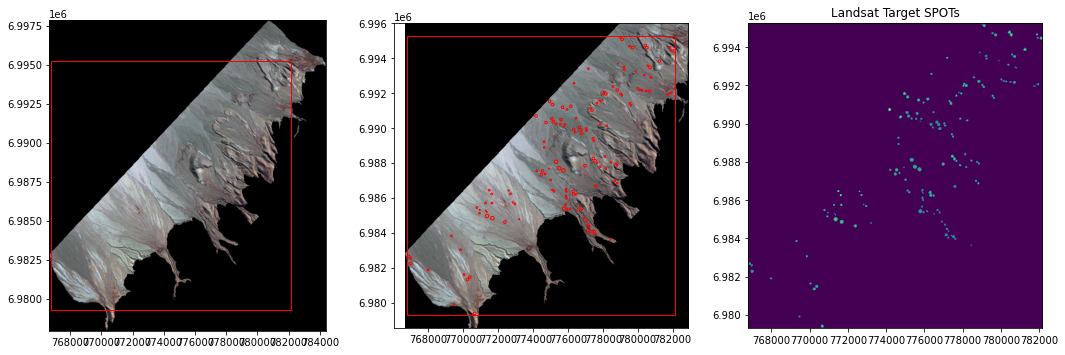

{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': 0.0,
 'width': 590,
 'height': 663,
 'count': 7,
 'crs': CRS.from_epsg(32719),
 'transform': Affine(30.0, 0.0, 766665.0,
        0.0, -30.0, 6997855.0)}

In [12]:
### LOCATE TARGET FILES ### (*manual*)
#locate files
target_data_file = r'C:\Users\htccr\Documents\Aconquija\imagery\landsat8\export\clipped\Landsat8_SR_stacked_clipped-surfaces_BCET.tif'
polygon_file = r'C:\Users\htccr\Documents\Aconquija\GIS_data\SPOTS_1_python.shp'

sensor = 'Landsat'

## READ IN FILES
# Multiband Raster
data_src = rio.open(target_data_file, 'r')
data_profile = data_src.profile
count = data_profile['count'] # How many bands are in our image?

# RGB raster (for plotting)
rgb_file = parent_dir + '\outputs\\aconquija_Landsat642.tif' # use 'RGB_composite.ipynb' to create RGB
rgb_src = rio.open(rgb_file, 'r')

# Polygons i.e Spots
polygons = gpd.read_file(polygons_file)

# create Geodataframe feature of polygons full extent (for plotting)
bbox_polygons = box(*polygons.total_bounds)
bbox_polygons = gpd.GeoDataFrame({"id":1,"geometry":[bbox_polygons]}) # create Geodataframne of the total extent of the polygon shapefile (for plotting)
extent_polygons = np.array(polygons.total_bounds) # extract numerical values for the polygons total extent (for plotting)

# mask and keep only pixels within polygons
masked, mask_transform = mask(dataset=data_src, shapes=polygons.geometry, crop=True, all_touched  = False, nodata = data_profile['nodata']) # mask pixs not within polygons i.e. Spots

## MOE MINUM N function
# function to determine minimum number (n) pixels to reach a designated Margin of Error given a specific confident interval (z score)
def margin_of_error(z, std, MOE):
    n_required = ((z*std)/MOE)**2
    return(n_required)

z = 1.96 # i.e 95% confidence interval (*manual*)
MOE = 250 # reflectance (*manual*)


## PLOT AND CHECK
saveIt = 0

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15,5))

show(rgb_src, ax = ax1)
bbox_polygons.plot(ax = ax1, facecolor = 'none', edgecolor = 'red')

show(rgb_src, ax = ax2)
bbox_polygons.plot(ax = ax2, facecolor = 'none', edgecolor = 'red')
polygons.plot(ax = ax2, facecolor = 'none', edgecolor = 'red')
ax2.set_xlim(extent_polygons[0] - 750, extent_polygons[2]+ 750)
ax2.set_ylim(extent_polygons[1] - 750, extent_polygons[3]+ 750)

show(masked[0], transform = mask_transform, ax = ax3) # optionally trasnform into geospatial coordinates, from mask meta. Plotting band 1 pix

plt.title('{} Target SPOTs'.format(sensor))
plt.tight_layout()
plt.show()

if saveIt:
    plt.savefig(parent_dir + '\outputs\\pix_converge_Q7_random.tif') # (*manual*)
    
plt.show()

# image metadata
data_src.meta

{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': 0.0,
 'width': 590,
 'height': 663,
 'count': 7,
 'crs': CRS.from_epsg(32719),
 'transform': Affine(30.0, 0.0, 766665.0,
        0.0, -30.0, 6997855.0)}

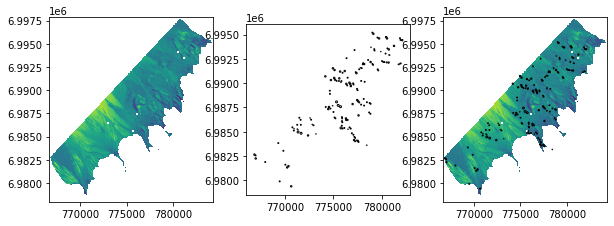

In [3]:
## READ IN DATA 

#locate files
image_file = r'C:\Users\htccr\Documents\Aconquija\imagery\landsat8\export\clipped\Landsat8_SR_stacked_clipped-surfaces_BCET.tif'
polygons_file = r'C:\Users\htccr\Documents\Aconquija\GIS_data\SPOTS_1_python.shp'

# read in files
image = rio.open(image_file, mode = 'r')
polygons = gpd.read_file(polygons_file)

# plot as check
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (10,5))
show(image, ax = ax1)

polygons.plot(ax = ax2, facecolor = 'none', edgecolor = 'black')

show(image, ax = ax3)
polygons.plot(ax = ax3, facecolor = 'none', edgecolor = 'black')

# image metadata
image.meta

In [47]:
## Calculate raster statistics of each polygon i.e. fan, for each band 
# see for zonal_stats function info: https://pythonhosted.org/rasterstats/manual.html#zonal-statistics

meta = data_src.meta # variable for accessing meta data
affine = data_src.transform # record affine for stats below

# choose statistics to calculate
stats = ['mean', 'std', 'count'] # see default options from zonal_stats

# create empty array to fill with polygon attributes and new raster stats data from each fan, for each band
pix_stat_array = np.empty((meta['count'], len(polygons)), dtype = dict) # dtype only works as dict, list, or object (?)

# calculate zonal statistics    
for i in range(meta['count']): # for i in range of bands
    ii = i + 1
    image_array = image.read(ii) # read image at that band
    
    # calcuate new statistics and fill empty array with existing attributes and these.  
    pix_stat_array[i] = rasterstats.zonal_stats(polygons, image_array, affine = affine, # image array is unique!
                                                stats = stats, # new stats 
                                                nodata = 0.0,
                                                geojson_out = True, # keep existing polygon attributes
                                                all_touched = False) # include edge pix? False means no

In [32]:
gen_zonal_stats?

Object `gen_zonal_stats` not found.


In [48]:
# check for new statistics!
pix_stat_array[0][0]['properties'] #array[band][unique fan]['properties i.e. attributes]

{'FIRST_Unit': 'Q3',
 'FIRST_fan': 'Co',
 'FIRST_uniq': '130CoQ3',
 'Id': 0,
 'Join_Count': 1,
 'MEAN_abs_a': 107.699996948,
 'MEAN_age_n': 1.0,
 'MEAN_age_s': 22.1000003815,
 'SUM_area': 2676195.0,
 'TARGET_FID': 0,
 'unique': '130CoQ3',
 'mean': 26007.625,
 'count': 8,
 'std': 946.2820585718615}

In [129]:
# extract statistics from array, and create dataframe 
# 1. extract existing properties stores in the polygons e.g. age, unique id, etc.
# 2. create base dataframe, drop first set of new stats 
# 3. Loop through all unique fan surfaces i.e. polygons, by band and extract new statistics into lists
# 4. Append new stats list to the dataframe

properties_list = [] # create empty list to store 
for jj in range(len(polygons)): # for each fan...
    properties_list.append(pix_stat_array[0][jj]['properties']) # extract all properties i.e. existing attributes & new stats. 
    # ^ append to empty list

df = pd.DataFrame(properties_list) # create dataframe from list
df = df.drop(columns=stats) # drop the first 


for ii in range(meta['count']):
    mean_pix_list = []
    std_pix_list = []
    pix_count_list = []
    for jj in range(len(polygons)):
        mean_pix_list.append(pix_stat_array[ii][jj]['properties']['mean'])
        pix_count_list.append(pix_stat_array[ii][jj]['properties']['count'])
        std_pix_list.append(pix_stat_array[ii][jj]['properties']['std'])
        
    
    df['B{}_mean'.format(ii + 1)] = mean_pix_list
    df['B{}_std'.format(ii + 1)] = std_pix_list
df['pix_count'] =  pix_count      
df.head()

FIRST_Unit FIRST_fan FIRST_uniq  Id  Join_Count  MEAN_abs_a  MEAN_age_n  \
0         Q3        Co    130CoQ3   0           1  107.699997         1.0   
1         Q3        Co    130CoQ3   0           1  107.699997         1.0   
2         Q3        Co    130CoQ3   0           1  107.699997         1.0   
3         Q3        Co    130CoQ3   0           1  107.699997         1.0   
4         Q3        Co    130CoQ3   0           1  107.699997         1.0   

   MEAN_age_s   SUM_area  TARGET_FID  ...      B3_std       B4_mean  \
0        22.1  2676195.0           0  ...  917.460456  26821.125000   
1        22.1  2676195.0           1  ...  920.525904  30771.600000   
2        22.1  2676195.0           2  ...  643.818453  29506.555556   
3        22.1  2676195.0           3  ...  641.019391  30895.375000   
4        22.1  2676195.0           4  ...  955.044269  28673.444444   

       B4_std       B5_mean       B5_std       B6_mean       B6_std  \
0  994.922665  28069.250000  1010.381085  29834.250000  1902.686440   
1  921.064297  30629.750000   892.079418  31908.900000  1003.716539   
2  555.500397  29360.722222   540.552475  30558.277778   478.199610   
3  613.308841  30676.500000   473.834887  31493.875000   620.438441   
4  987.797000  28611.777778  1052.546624  29714.555556  1011.505051   

        B7_mean       B7_std  pix_count  
0  28798.625000  1801.693505          8  
1  32427.200000   816.928675         20  
2  31639.222222   431.487550         18  
3  32574.125000   707.724777          8  
4  31105.555556   966.739665          9  

[5 rows x 26 columns]

In [232]:
# if the age in the df match the index age of the pixel count dataframe (ppix counts), append the value of pixel count to the temp_list (then we will use this to calulated weight for weighted mean)

temp_list = []

for i in range(np.shape(df)[0]):
    if df['MEAN_abs_a'][i] == [pix_counts.index.values[j] for j in range(np.shape(pix_counts)[0])]:
        temp_list.append(pix_counts[j])

                               

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [177]:
# count pixels in each age group
pix_counts = df[['MEAN_abs_a', 'pix_count']]
pix_counts = df_temp.groupby(['MEAN_abs_a']).sum()
pix_counts



pix_count
MEAN_abs_a           
0.000000          209
3.370000            7
5.106670           88
5.300000           28
5.400000           84
6.250000           18
7.690000           67
11.330000         105
16.450001          52
16.480000          47
17.670000          76
18.200001          86
22.010000          53
26.299999          85
30.500000          17
31.743299          86
78.500000          35
107.699997         63
117.900000        104
160.265000         94
212.154007        146
238.470001         67
286.800000         71
314.485000         14
319.220001         60

In [141]:
#df_temp = df[['B{}_mean'.format(i + 1) for i in range(meta['count'])]]
df_temp.loc[:,'age'] = df['MEAN_abs_a']
#df_test.groupby([])
df_temp = df_temp.groupby(['age']).mean()

df_temp

B1_mean       B2_mean       B3_mean       B4_mean  \
age                                                                  
0.000000    37341.102528  37922.449966  38330.030091  37284.523443   
3.370000    28183.500000  28502.583333  28249.083333  28384.708333   
5.106670    28052.095000  29076.330000  29811.075000  29670.285000   
5.300000    39560.144444  39158.791667  39413.108333  39407.850000   
5.400000    32906.669907  32720.533796  32735.280556  33057.155093   
6.250000    31887.111111  32225.277778  31923.972222  31832.500000   
7.690000    33743.013047  33441.406481  33105.852357  33311.573737   
11.330000   37238.036689  36801.853074  37260.754527  37253.958243   
16.450001   29450.567982  29489.704971  29373.543567  29313.076901   
16.480000   25785.775000  25871.789474  25251.443421  26134.213158   
17.670000   28657.327447  28617.697817  28114.455886  28565.738757   
18.200001   33995.941019  33475.946617  34036.656168  34998.460011   
22.010000   30214.121493  30206.479798  30151.980640  30411.013187   
26.299999   34413.522676  34162.013719  33765.474717  33956.377494   
30.500000   38596.718750  38021.260417  38183.479167  38052.687500   
31.743299   29253.553425  29969.126587  30565.516604  30497.833229   
78.500000   27394.229898  27897.522661  28572.621345  29422.432383   
107.699997  29402.365556  28681.993889  28607.039444  29333.620000   
117.900000  36118.353175  35516.001984  36227.224802  37301.393651   
160.265000  36375.506798  35980.082505  35494.123709  35713.513304   
212.154007  30082.679110  29709.111752  29249.318829  29990.892985   
238.470001  31183.794444  31300.722222  31359.316667  32722.425000   
286.800000  37000.157407  37165.620370  36996.979167  37750.270833   
314.485000  29792.851852  30366.685185  31091.777778  32657.888889   
319.220001  32905.275794  32714.658730  32642.033730  33853.160714   

                 B5_mean       B6_mean       B7_mean  
age                                                   
0.000000    35914.714405  35667.807534  36976.411197  
3.370000    27948.750000  29041.416667  29067.000000  
5.106670    28649.015000  27089.135000  28173.685000  
5.300000    38550.744444  40130.808333  38648.477778  
5.400000    32510.908333  32114.273611  33485.383796  
6.250000    31189.527778  32186.472222  33544.638889  
7.690000    32157.311448  32690.549916  33719.006397  
11.330000   36007.320405  37216.903750  35405.691081  
16.450001   27821.752632  28675.572222  30523.969591  
16.480000   28274.413158  29249.575000  27826.171053  
17.670000   28654.821098  29333.147751  30243.689220  
18.200001   35134.599165  37616.431607  35718.724756  
22.010000   29759.359989  30194.036756  31485.412177  
26.299999   32647.621032  32302.782880  34800.978118  
30.500000   36846.364583  37853.645833  36333.645833  
31.743299   29975.233145  28261.343379  29721.178008  
78.500000   31684.296053  33316.006579  31864.004386  
107.699997  29469.600000  30701.971667  31308.945556  
117.900000  37374.867262  39810.479762  37618.412302  
160.265000  35550.011598  37313.438767  38523.417861  
212.154007  30026.135717  30684.670559  31296.833734  
238.470001  33899.205000  35655.503333  34015.366667  
286.800000  38621.912037  41979.562500  40528.034722  
314.485000  35835.500000  37625.648148  34722.333333  
319.220001  34566.781746  35712.587302  34240.251984

In [79]:
bands_only = df.drop(columns=['FIRST_Unit', 'FIRST_fan','FIRST_uniq','Id', 'Join_Count', 'MEAN_age_n', 'MEAN_age_s', 'SUM_area','TARGET_FID', 'unique']) # drop specified columns
bands_only = bands_only.drop(columns = ['B{}_std'.format(i) for i in range(1, meta['count'] + 1)])

bands_age = bands_only.groupby(['MEAN_abs_a'], dropna = False).tt()

AttributeError: 'DataFrameGroupBy' object has no attribute 'tt'

In [75]:
pix_total = df['pix_count'].sum()
weight_list = df['pix_count']/df['pix_count'].sum()

df_test = df[['B{}_mean'.format(i + 1) for i in range(meta['count'])]] * [weight_list[j] for j in range(np.shape(df)[0])]
df_test

ValueError: Unable to coerce to Series, length must be 7: given 150

In [8]:
# Create 'clean' dataframe without modern (i.e. age = 0), or rock avalanch "Av" units. 
clean = df.drop(df[df.Unit == "Modern"].index)
clean = clean.drop(clean[clean.Unit == "Av"].index)


AttributeError: 'DataFrame' object has no attribute 'Unit'

In [ ]:
# Plot spectral signature as bands

#bands_only = df.drop(columns=['Unit', 'unique','age_n','age_sd','area','fan']) # drop specified columns
bands_only = df.drop(columns=['FIRST_Unit', 'FIRST_fan','FIRST_uniq','Id', 'Join_Count', 'MEAN_age_n', 'MEAN_age_s', 'SUM_area','TARGET_FID', 'unique']) # drop specified columns
#bands_only = df.drop(columns=['MEAN_abs_a', 'FIRST_fan','FIRST_uniq','Id', 'Join_Count', 'MEAN_age_n', 'MEAN_age_s', 'SUM_area','TARGET_FID', 'unique'])

bands_only = bands_only.drop(columns = ['B{}_std'.format(i) for i in range(1, meta['count'] + 1)])

In [36]:
# Group rows of same UNIT and take mean
# I will likley have to rewrite this code to sample every SPOT seperatly, then group all the SPOTS together based on the uniqueID. This way we can carry standard deviations though. 

bands_only = df.drop(columns=['MEAN_abs_a', 'FIRST_fan','FIRST_uniq','Id', 'Join_Count', 'MEAN_age_n', 'MEAN_age_s', 'SUM_area','TARGET_FID', 'unique'])
bands_only = bands_only.drop(columns = ['B{}_std'.format(i) for i in range(1, meta['count'] + 1)])
bands_only['FIRST_Unit'] = bands_only['FIRST_Unit'].replace(['Modern'],'Q8 (modern)')

bands_unit = bands_only.groupby(['FIRST_Unit'], dropna = True).mean() # group rows, take mean of variables, and also sorts by group value 

# extract ages index for plotting
band_names = np.array(bands_unit.columns.values)
unit_names = np.array(bands_unit.index.values)

In [46]:
bands_only = df.drop(columns=['FIRST_Unit', 'FIRST_fan','FIRST_uniq','Id', 'Join_Count', 'MEAN_age_n', 'MEAN_age_s', 'SUM_area','TARGET_FID', 'unique']) # drop specified columns
bands_only = bands_only.drop(columns = ['B{}_std'.format(i) for i in range(1, meta['count'] + 1)])

bands_only

MEAN_abs_a       B1_mean       B2_mean       B3_mean       B4_mean  \
0    107.699997  26007.625000  25502.000000  25383.750000  26821.125000   
1    107.699997  31109.550000  30307.400000  30256.600000  30771.600000   
2    107.699997  29709.277778  28923.888889  28942.722222  29506.555556   
3    107.699997  31196.375000  30443.125000  30269.125000  30895.375000   
4    107.699997  28989.000000  28233.555556  28183.000000  28673.444444   
..          ...           ...           ...           ...           ...   
145  160.265000  37302.105263  37005.052632  36606.263158  37082.210526   
146  160.265000  39197.526316  38460.526316  37901.105263  38059.105263   
147  160.265000  36673.684211  36421.210526  35867.421053  35907.947368   
148  160.265000  38378.000000  38319.555556  38034.777778  38042.666667   
149  160.265000  28468.625000  28054.500000  27583.375000  27965.250000   

          B5_mean       B6_mean       B7_mean  
0    28069.250000  29834.250000  28798.625000  
1    30629.750000  31908.900000  32427.200000  
2    29360.722222  30558.277778  31639.222222  
3    30676.500000  31493.875000  32574.125000  
4    28611.777778  29714.555556  31105.555556  
..            ...           ...           ...  
145  36840.052632  38678.105263  39997.421053  
146  37608.000000  38304.473684  39518.052632  
147  35769.894737  38786.684211  40343.947368  
148  37919.222222  39860.444444  41142.111111  
149  27833.000000  29135.625000  29999.375000  

[150 rows x 8 columns]

In [38]:
# Group rows of same age (e.g. 0.0) and take mean
# I will likley have to rewrite this code to sample every SPOT seperatly, then group all the SPOTS together based on the uniqueID. This way we can carry standard deviations though. 
#bands = bands_only.groupby(['abs_age'], dropna = False).mean() # group rows, take mean of variables, and also sorts by group value 

bands_only = df.drop(columns=['FIRST_Unit', 'FIRST_fan','FIRST_uniq','Id', 'Join_Count', 'MEAN_age_n', 'MEAN_age_s', 'SUM_area','TARGET_FID', 'unique']) # drop specified columns
bands_only = bands_only.drop(columns = ['B{}_std'.format(i) for i in range(1, meta['count'] + 1)])

bands_age = bands_only.groupby(['MEAN_abs_a'], dropna = False).mean() # group rows, take mean of variables, and also sorts by group value 

# extract ages index for plotting
band_names = np.array(bands_age.columns.values)
ages = np.array(bands_age.index.values.astype(float))
ages = np.round(ages, 2)

In [20]:
# normalize data
norm_across_band = (bands_unit.T - bands_unit.T.mean())/bands_unit.T.std()

norm_same_band = (bands_unit - bands_unit.mean())/bands_unit.std() # normalize data for each individual bands i.e. each band has a mean spectral reflectance mean(B1) across observations
norm_same_band_across = (norm_same_band.T - norm_same_band.T.mean())/norm_same_band.T.std() # normalized the normalized individual bands, across all bands i.e. across the spectrum

#scaled01 = (norm_same_band_across - norm_same_band_across.min())/(norm_same_band_across.max() - norm_same_band_across.min()) # scale to 0 to 1 range, seems incorrect

NameError: name 'bands_unit' is not defined

In [21]:
# normalize data
norm_across_band = (bands_age.T - bands_age.T.mean())/bands_age.T.std()

norm_same_band = (bands_age - bands_age.mean())/bands_age.std() # normalize data for each individual bands i.e. each band has a mean spectral reflectance mean(B1) across observations
norm_same_band_across = (norm_same_band.T - norm_same_band.T.mean())/norm_same_band.T.std() # normalized the normalized individual bands, across all bands i.e. across the spectrum

#scaled01 = (norm_same_band_across - norm_same_band_across.min())/(norm_same_band_across.max() - norm_same_band_across.min()) # scale to 0 to 1 range, seems incorrect

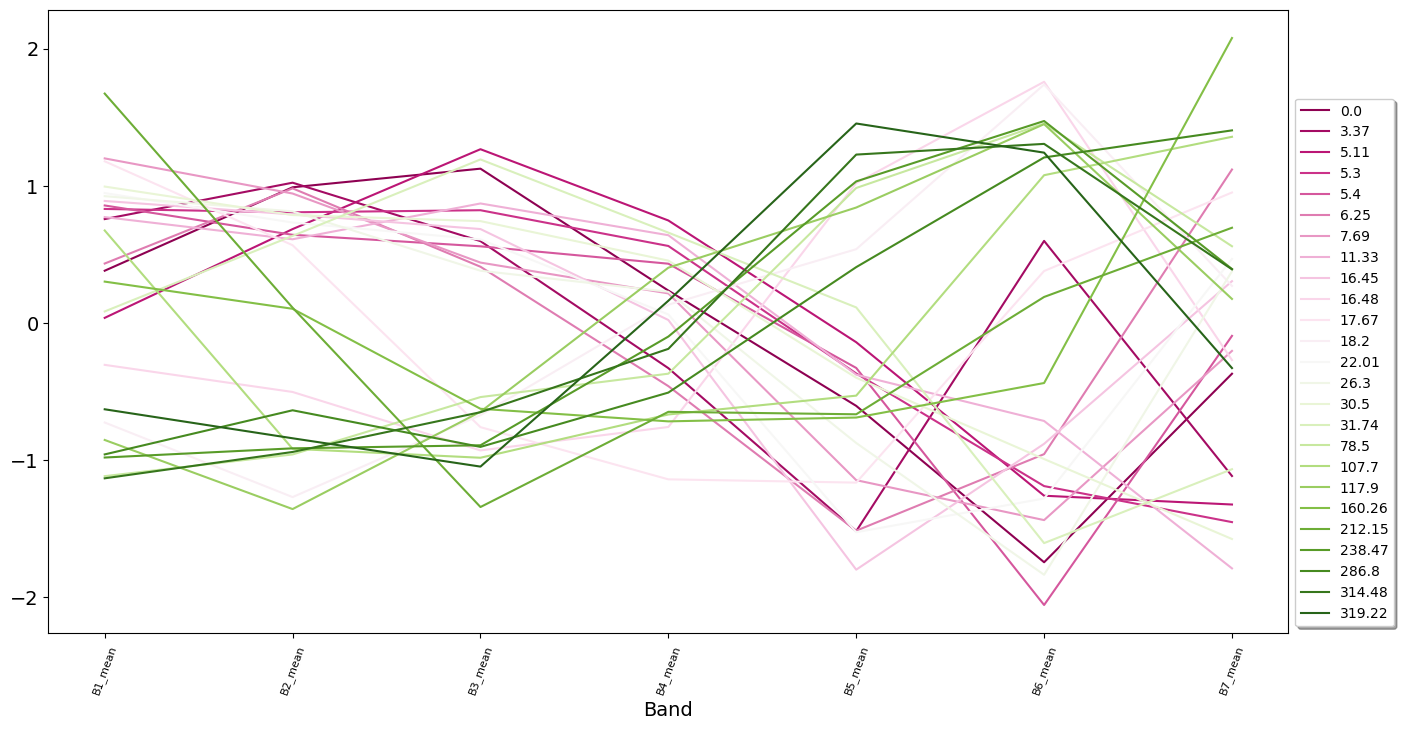

In [26]:
target = norm_same_band_across.T
target_names = ages

N = len(target) # number of objects to plot i.e. color cycle count

plt.rcParams["figure.figsize"] = [16,9] # fig size
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.PiYG(np.linspace(0,1,N))) # colors to cycle through, choose default like 'viridis' or 'PiYG'

fig, ax = plt.subplots()
for i in range(N):
    ax.plot(target.iloc[i], label = target_names[i]) # for i in range of objects, plot x,y

#plt.legend(loc = 'right')
plt.xlabel('Band', fontsize = 14)
plt.xticks(fontsize = 10, rotation=70, size = 8)
plt.yticks(fontsize = 14)

# cutum legend location
# get legend location
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='lower left', bbox_to_anchor=(1, 0),
          fancybox=True, shadow=True, ncol=1)

plt.rcdefaults() # reset global plt parameters, IMPORTANT!
plt.show()

In [ ]:
normed = norm_across_band

#scaled01 = (bands - bands.min())/(bands.max() - bands.min()) # scale to 0 to 1 range, seems incorrect

N = len(target) # number of objects to plot i.e. color cycle count

plt.rcParams["figure.figsize"] = [16,9] # fig size
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.PiYG(np.linspace(0,1,N))) # colors to cycle through, choose default like 'viridis' or 'PiYG'

fig, ax = plt.subplots()
for i in range(N):
    ax.plot(normed.T.iloc[i], label = target_names[i]) # for i in range of objects, plot x,y
    
plt.xlim(90,200)

#plt.legend(loc = 'right')
plt.xlabel('Band', fontsize = 14)
plt.xticks(fontsize = 10, rotation=70, size = 8)
plt.yticks(fontsize = 14)

# cutum legend location
# get legend location
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='lower left', bbox_to_anchor=(1, 0),
          fancybox=True, shadow=True, ncol=1)

plt.rcdefaults() # reset global plt parameters, IMPORTANT!
plt.show()

In [ ]:
ratio = (normed.iloc[104] + abs(test.T.iloc[20]))

plt.figure()
plt.scatter(unit_names, ratio)

In [ ]:
test = norm_across_band.T

ratio = abs(test.T.iloc[20])


plt.figure()
plt.scatter(unit_names, ratio,  c = 'red')


In [ ]:
bands.T.iloc[0]

In [ ]:


plt.figure()
plt.scatter(unit_names, normed.iloc[20])
plt.xlabel('Age')
plt.ylabel('Rel. Reflectance')
plt.title('B42/2 (VIS)')
plt.xlim()


In [27]:
# Export final dataframe
export = norm_same_band_across # choose df to export

export.to_csv(parent_dir + '\outputs\\SPOTS_landsat_normall_BCET.csv', header = True) # '\selected_folder\\filename.file-type'

In [ ]:
# spot sample and clean up variance
# remove mean and create anomalies
# Use PCs
# extract ages as an array and do plt.plot(PCs[:,kk], ages)

# reconstruct the new data using the first few PCs of model-built data, nit neccisarily the index. 

In [ ]:
# KEEP FOR EXAMPLE/ SAFE KEEPING

In [ ]:
N = 28 # number of objects to plot i.e. color cycle count

plt.rcParams["figure.figsize"] = [16,9] # fig size
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.PiYG(np.linspace(0,1,N))) # colors to cycle through, choose default like 'viridis' or 'PiYG'

fig, ax = plt.subplots()
for i in range(N):
    ax.plot(data[i], label = data.index.values.astype(float)[i]) # for i in range of objects, plot x,y

#plt.legend(loc = 'right')
plt.xlabel('Band', fontsize = 14)
plt.xticks(fontsize = 10, rotation=70, size = 8)
plt.yticks(fontsize = 14)

# cutum legend location
# get legend location
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='lower left', bbox_to_anchor=(1, 0),
          fancybox=True, shadow=True, ncol=1)

plt.rcdefaults() # reset global plt parameters, IMPORTANT!
plt.show()

In [ ]:
# re-run itrative list but just collecting band information

age_list = [] # create empty list to store 
for jj in range(len(polygons)): # for each fan...
    age_list.append(pix_stat_array[0][jj]['properties']['abs_age']) # extract all properties i.e. existing attributes & new stats. 
    # ^ append to empty list

bands_only = pd.DataFrame({'age': age_list}) # create dataframe from list


for ii in range(meta['count']):
    mean_pix_list = []
    #std_pix_list = []
    for jj in range(len(polygons)):
        mean_pix_list.append(pix_stat_array[ii][jj]['properties']['mean'])
        #std_pix_list.append(pix_stat_array[ii][jj]['properties']['std'])
    
    bands_only['B{}_mean'.format(ii + 1)] = mean_pix_list
    #df2['B{}_std'.format(ii + 1)] = std_pix_list
        
bands_only = bands_only.sort_values('age', axis=0, ascending=True) # sort dataframe by age
bands_only['age'] = round(bands_only['age'], 2) # round ages to 2 sig figs
